# Analisis_QCM.ipynb
# Proyecto Final - Clasificación de Alcoholes con QCM
# Autor: Yesenia Perez Brito

In [17]:
!pip install matplotlib seaborn

# Imports y configuración Spark + Matplotlib/Seaborn

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


# Carga de datos QCM3, QCM10, QCM12
Asignar nombres a los CSV que no tienen encabezados claros:
- QCM3.csv
- QCM10.csv
- QCM12.csv

In [19]:
qcm3 = pd.read_csv(r"C:\Users\PC\Documents\trae_projects\Proyecto_QCM\data\QCM3.csv", sep=";", header=0)
qcm10 = pd.read_csv(r"C:\Users\PC\Documents\trae_projects\Proyecto_QCM\data\QCM10.csv", sep=";", header=0)
qcm12 = pd.read_csv(r"C:\Users\PC\Documents\trae_projects\Proyecto_QCM\data\QCM12.csv", sep=";", header=0)

# 2. Renombra columnas (las que ya tienes)
cols = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10',
        'octanol','propanol','butanol2','propanol2','isobutanol']
qcm3.columns  = cols
qcm10.columns = cols
qcm12.columns = cols


qcm3["sensor"] = "QCM3"
qcm10["sensor"] = "QCM10"
qcm12["sensor"] = "QCM12"

data = pd.concat([qcm3, qcm10, qcm12], ignore_index=True)

# 5. Crear columna 'solvente' a partir de las one‑hot
class_cols = ["octanol", "propanol", "butanol2", "propanol2", "isobutanol"]

def one_hot_to_label(row):
    for c in class_cols:
        if row[c] == 1:
            return c
    return "desconocido"

data["solvente"] = data[class_cols].apply(one_hot_to_label, axis=1)

# Exploración inicial de cada dataset

In [20]:
# ejemplo genérico si solo hay valores y luego columnas one‑hot
n_features = 11  # número de columnas numéricas
feature_cols = [f"f{i+1}" for i in range(n_features)]
class_cols = ["octanol", "propanol", "butanol2", "propanol2", "isobutanol"]

cols = feature_cols + class_cols
qcm3.columns = cols
qcm10.columns = cols
qcm12.columns = cols


# Distribución de características numéricas

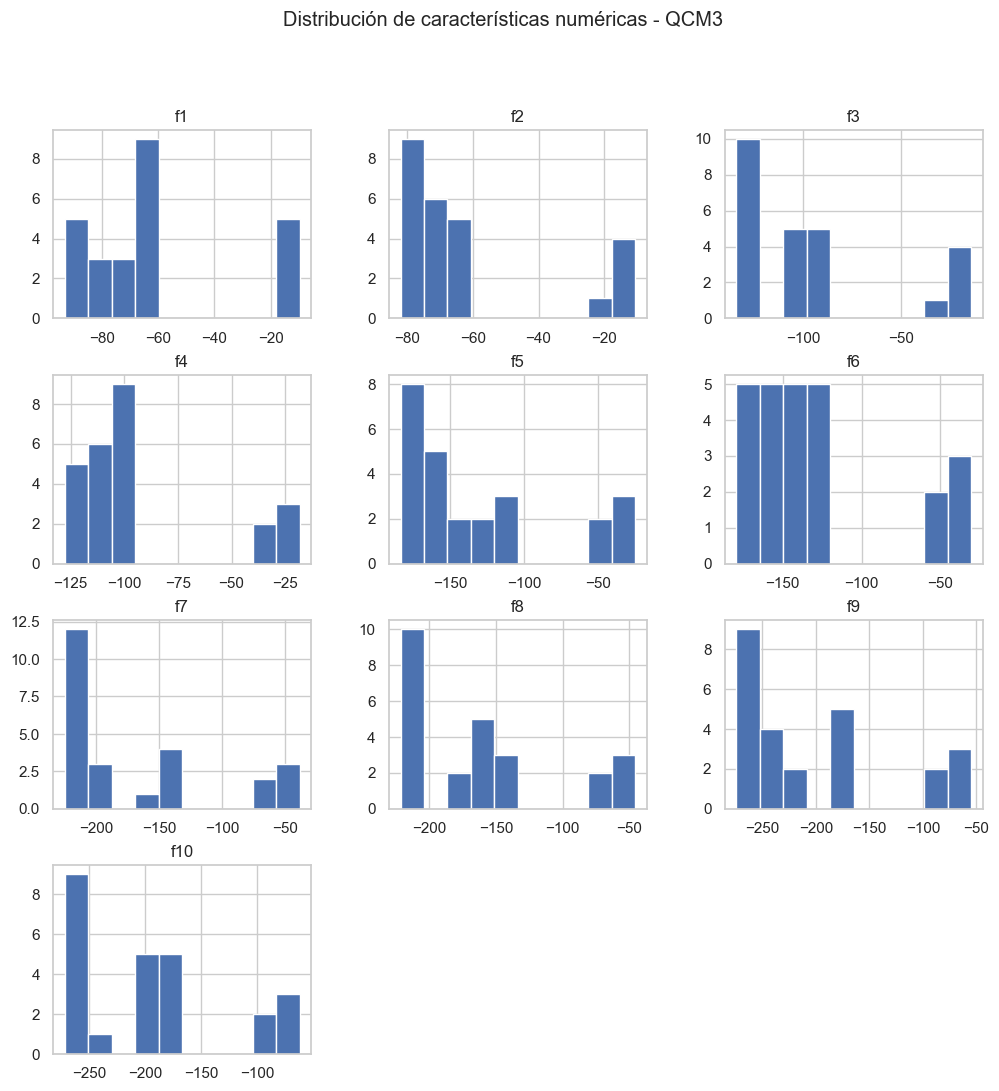

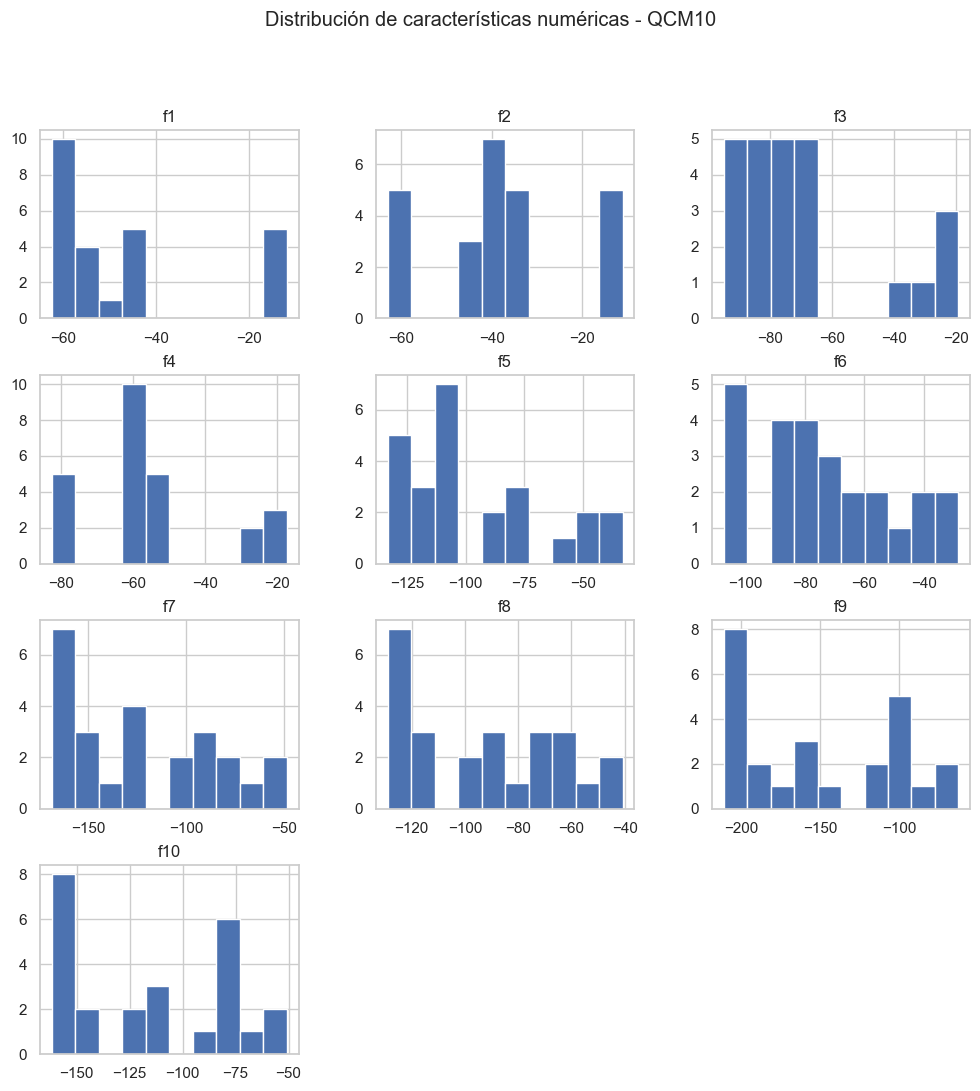

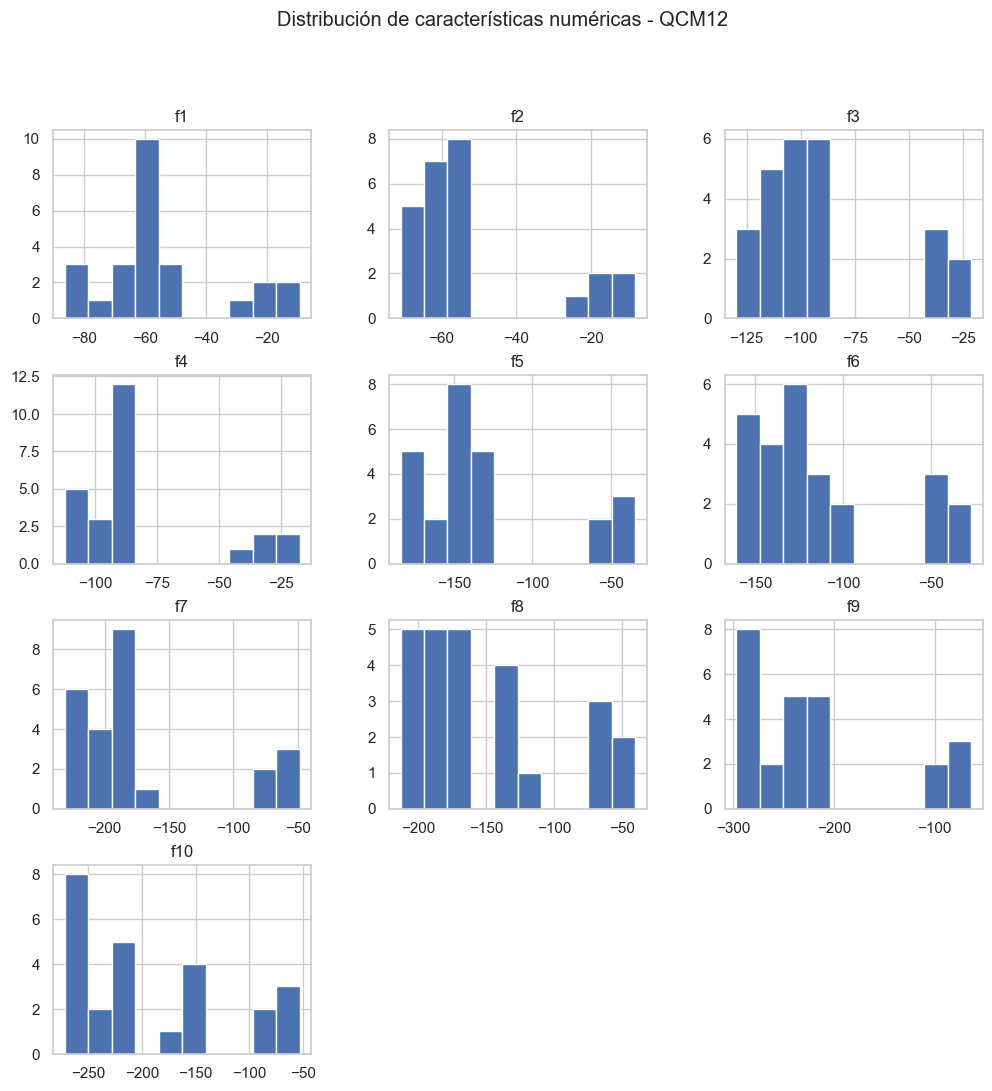

In [21]:
qcm3.iloc[:, :10].hist(figsize=(12, 12))
plt.suptitle("Distribución de características numéricas - QCM3")
plt.show()

qcm10.iloc[:, :10].hist(figsize=(12, 12))
plt.suptitle("Distribución de características numéricas - QCM10")
plt.show()

qcm12.iloc[:, :10].hist(figsize=(12, 12))
plt.suptitle("Distribución de características numéricas - QCM12")
plt.show()



# Análisis exploratorio (EDA)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,n_missing,n_unique
f1,75.0,NaN,NaN,NaN,-54.774667,23.242456,-93.29,-66.985,-60.23,-44.735,-9.4,0,74
f2,75.0,NaN,NaN,NaN,-50.756533,22.28829,-81.88,-67.615,-58.37,-35.33,-7.95,0,74
f3,75.0,NaN,NaN,NaN,-85.281867,34.049538,-133.96,-106.115,-94.15,-66.61,-14.43,0,75
f4,75.0,NaN,NaN,NaN,-77.167067,32.92015,-127.76,-104.575,-86.03,-50.955,-17.28,0,73
f5,75.0,NaN,NaN,NaN,-119.961733,46.906907,-183.94,-153.87,-131.05,-87.35,-24.64,0,75
f6,75.0,NaN,NaN,NaN,-106.2236,45.087069,-179.25,-139.16,-109.68,-65.97,-27.35,0,75
f7,75.0,NaN,NaN,NaN,-153.6292,59.067392,-231.08,-207.905,-165.33,-99.425,-38.62,0,75
f8,75.0,NaN,NaN,NaN,-135.409867,57.677783,-221.49,-181.645,-129.79,-77.745,-39.91,0,75
f9,75.0,NaN,NaN,NaN,-191.249867,73.593659,-296.68,-252.985,-207.16,-114.365,-54.89,0,74
f10,75.0,NaN,NaN,NaN,-168.480933,72.270205,-272.04,-242.515,-161.37,-98.24,-50.82,0,75


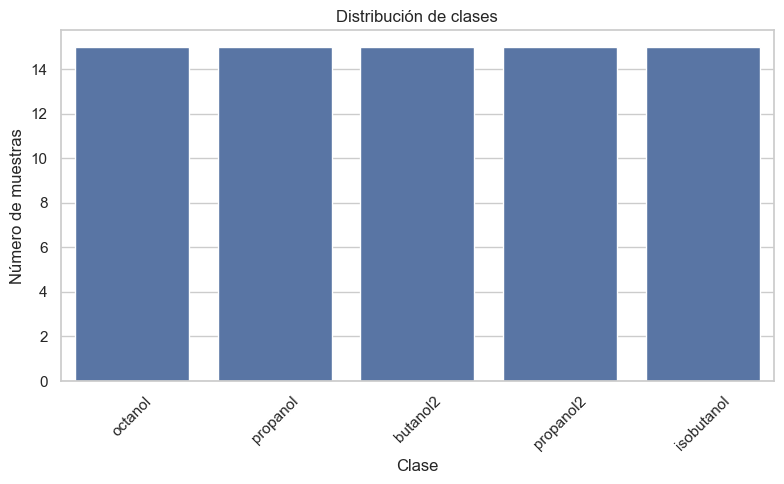

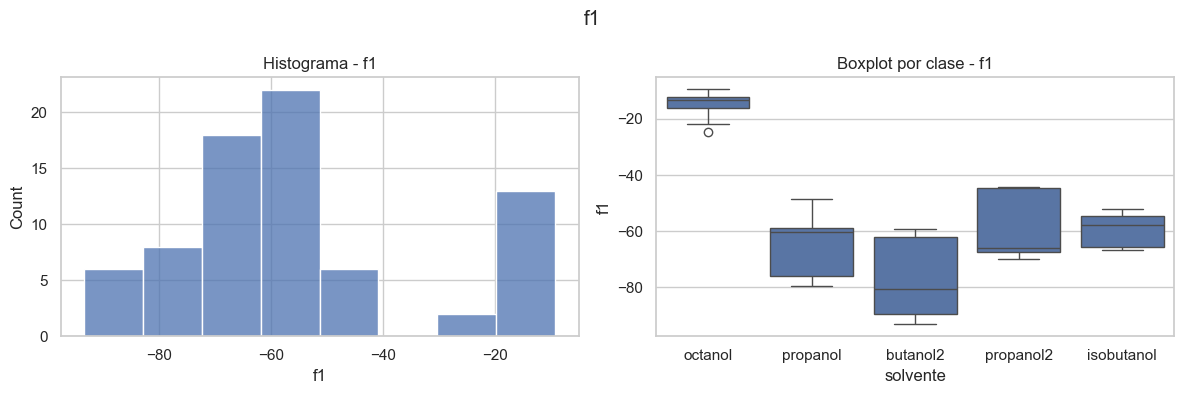

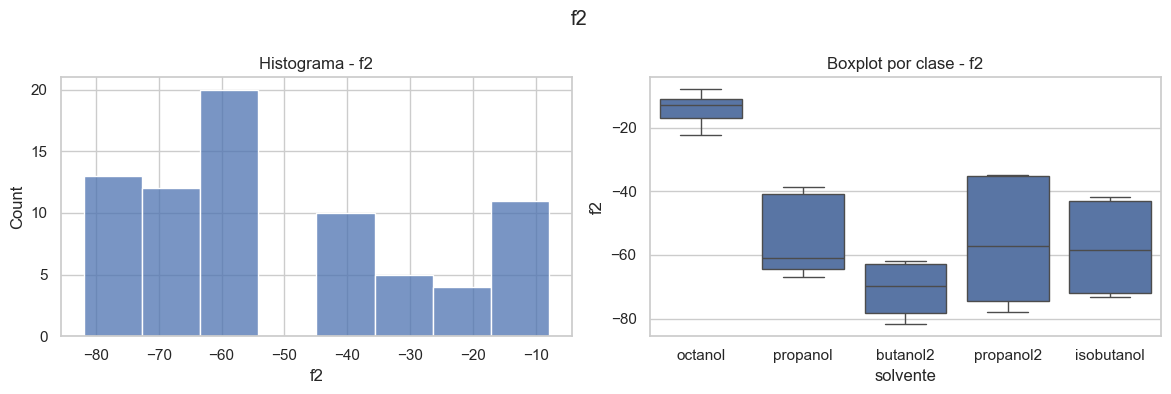

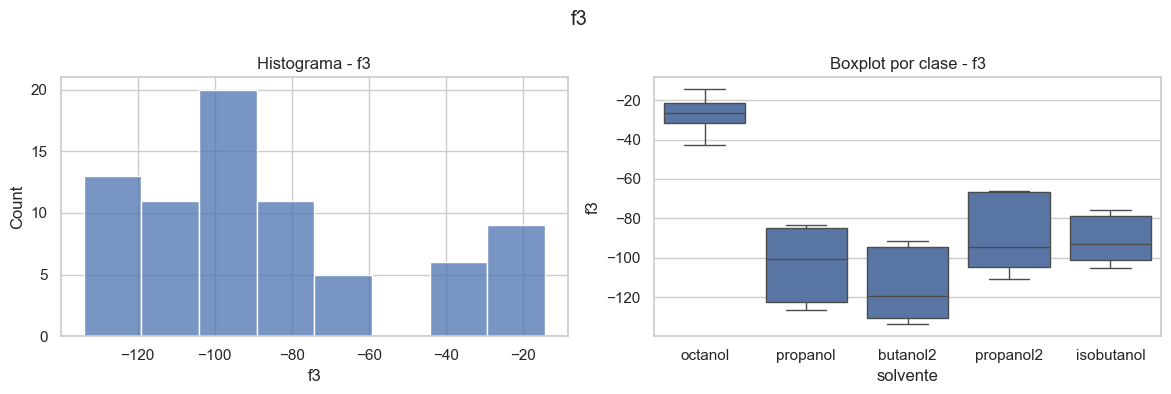

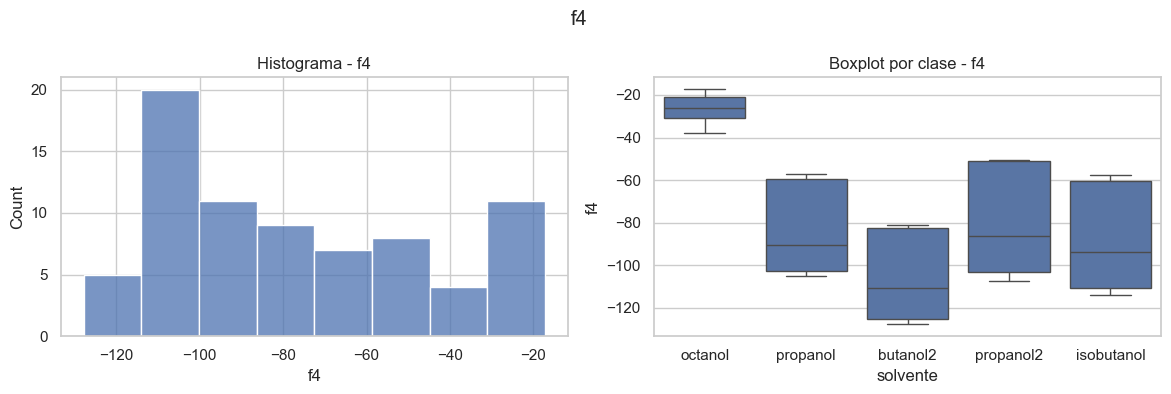

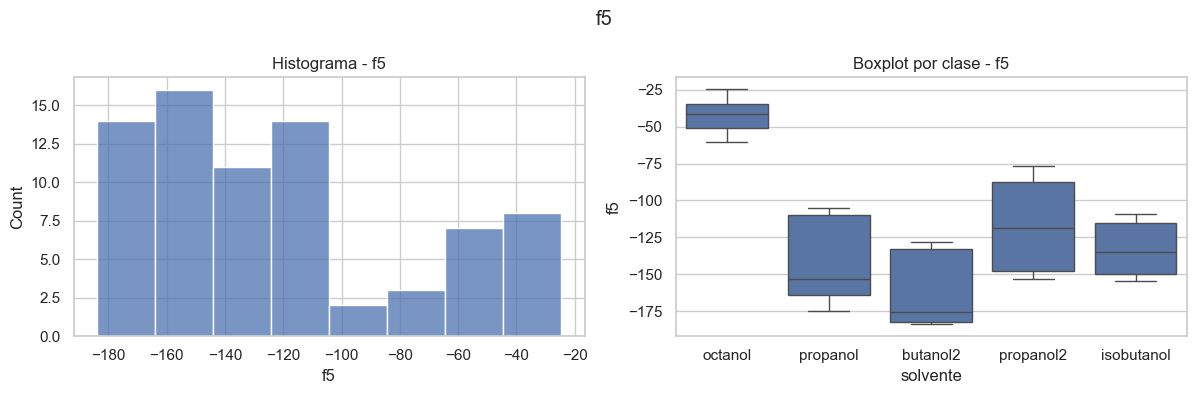

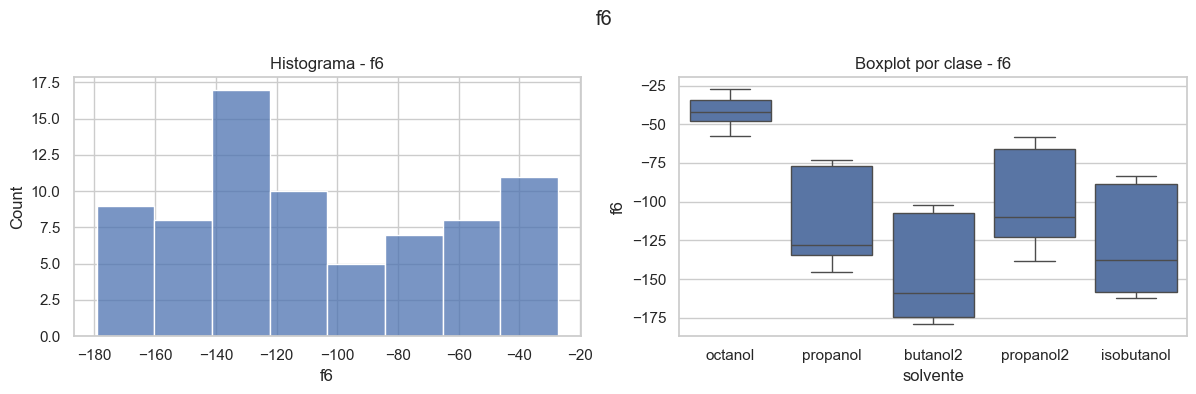

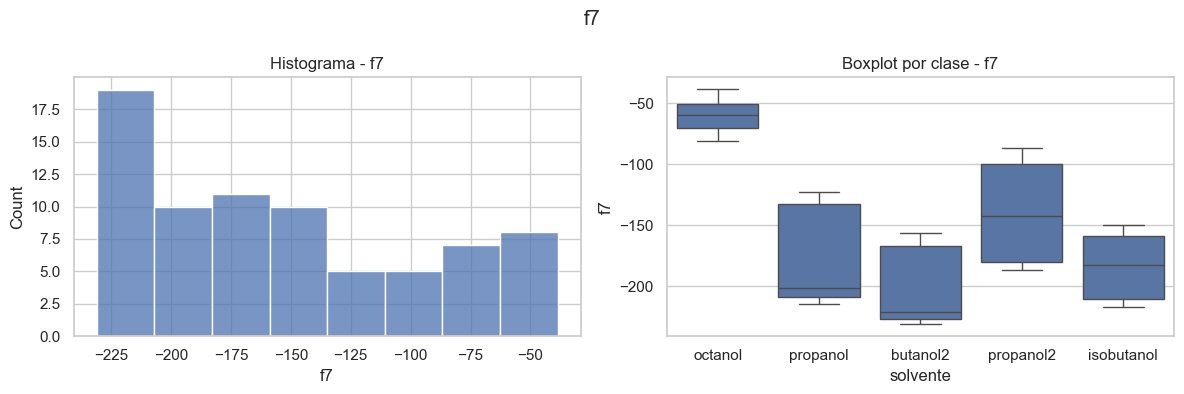

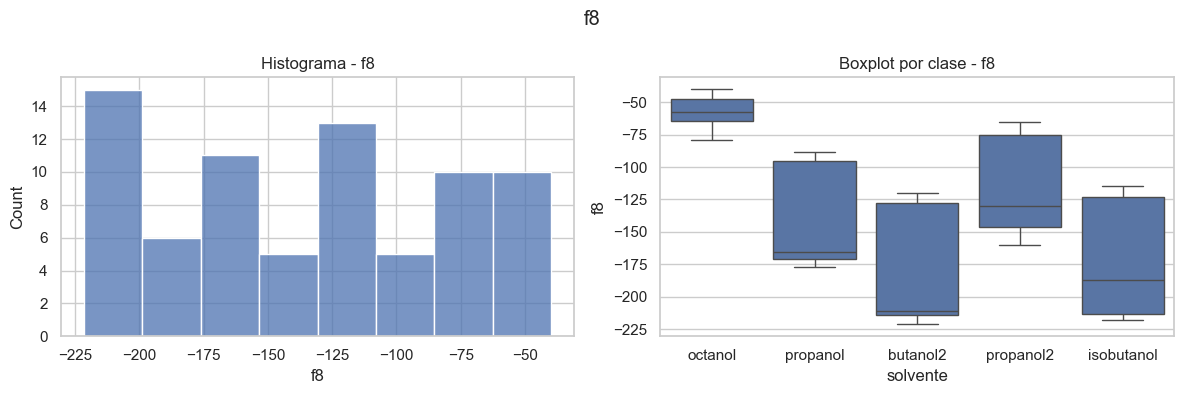

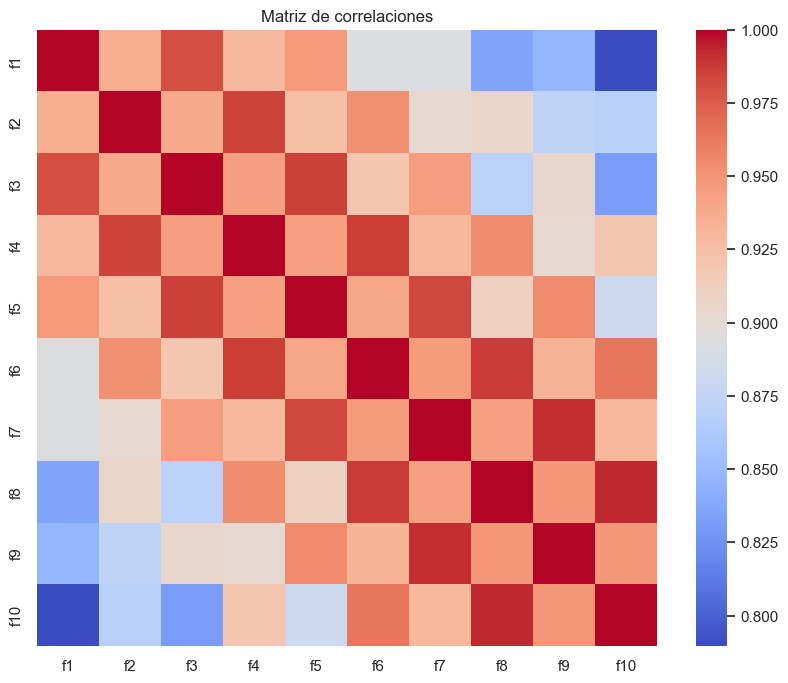

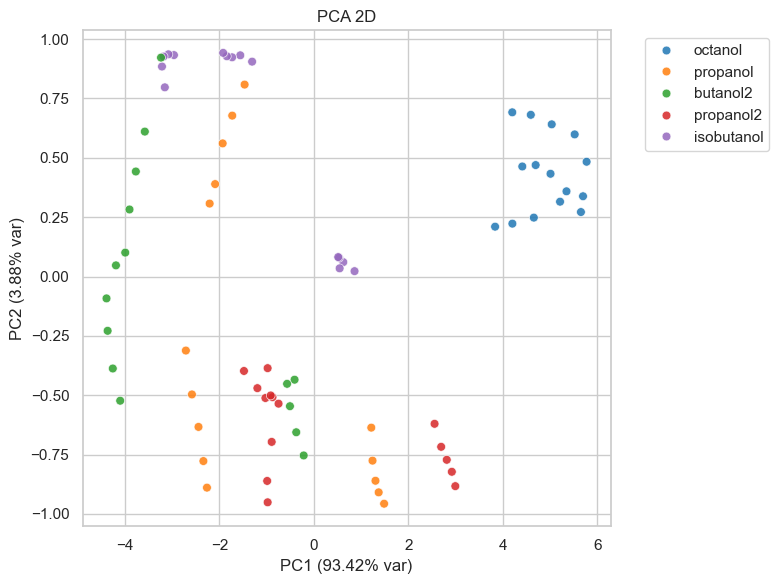

In [26]:
# -----------------------------
# Ejecutar EDA y mostrar todo
# -----------------------------
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

TARGET_COL = 'solvente'

# Comprobaciones rápidas
if 'data' not in globals():
    raise RuntimeError("No encuentro la variable `data` en el notebook. Carga primero tu DataFrame.")
if 'numeric_features' not in globals():
    raise RuntimeError("No encuentro la lista `numeric_features`. Define las columnas numéricas (ej. ['f1','f2',...]).")
if TARGET_COL not in data.columns:
    raise RuntimeError(f"No encuentro la columna target '{TARGET_COL}' en `data`.")

# Preparar X e y usando tus variables
X = data[numeric_features].copy()
y = data[TARGET_COL].copy()

# 1) Estadísticas descriptivas (se muestran en la celda)
desc = summary_statistics(data, outdir=None)   # outdir=None evita guardado
display(desc)

# 2) Distribución de clases (se muestra)
plot_class_distribution(y, outdir=None, show=True)

# 3) Histograma + boxplot para las primeras N características
N = min(8, X.shape[1])   # muestra hasta 8 para no saturar
for feat in X.columns[:N]:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(X[feat].dropna(), ax=axes[0])
    axes[0].set_title(f'Histograma - {feat}')
    sns.boxplot(x=y, y=X[feat], ax=axes[1])
    axes[1].set_title(f'Boxplot por clase - {feat}')
    plt.suptitle(feat)
    plt.tight_layout()
    plt.show()

# 4) Matriz de correlación (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), cmap='coolwarm', annot=False)
plt.title('Matriz de correlaciones')
plt.show()

# 5) PCA 2D (visual)
mask = X.dropna().index
Xs = X.loc[mask]
ys = y.loc[mask]

scaler = StandardScaler()
Xs_scaled = scaler.fit_transform(Xs)

pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(Xs_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=ys.astype(str), palette='tab10', s=40, alpha=0.85)
plt.title('PCA 2D')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# Comparar sensores

In [6]:
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

numeric_features = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']

# Función para evaluar UN sensor específico
def evaluar_sensor(df_completo, nombre_sensor):
    # FILTRAR data por sensor
    df_sensor = df_completo[df_completo['sensor'] == nombre_sensor].copy()
    
    if len(df_sensor) == 0:
        print(f"❌ No hay datos para {nombre_sensor}")
        return None, None
    
    X_sensor = df_sensor[numeric_features]
    y_sensor = df_sensor['solvente']
    
    # Split (con pocos datos usamos test_size=0.4 para tener test decente)
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X_sensor, y_sensor, test_size=0.4, random_state=42, stratify=y_sensor
    )
    
    scaler_s = StandardScaler()
    X_train_s_scaled = scaler_s.fit_transform(X_train_s)
    X_test_s_scaled = scaler_s.transform(X_test_s)
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_s_scaled, y_train_s)
    y_pred_s = knn.predict(X_test_s_scaled)
    
    # Métricas
    f1_macro = f1_score(y_test_s, y_pred_s, average='macro')
    
    # CV3 (con pocos datos)
    cv_scores = cross_val_score(knn, X_train_s_scaled, y_train_s, cv=3, scoring='f1_macro')
    
    print(f"\n=== {nombre_sensor} ===")
    print(f"  Datos: {len(df_sensor)} obs")
    print(f"  F1-macro TEST:  {f1_macro:.3f}")
    print(f"  F1-macro CV3:   {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print("\nReporte completo:")
    print(classification_report(y_test_s, y_pred_s))
    print("-" * 50)
    
    return f1_macro, cv_scores.mean()

# EJECUTAR (usa tu 'data' que ya tiene 'solvente')
print("ANÁLISIS COMPARATIVO POR SENSOR\n" + "="*50)
f1_qcm3,  cv_qcm3  = evaluar_sensor(data, "QCM3")
f1_qcm10, cv_qcm10 = evaluar_sensor(data, "QCM10")
f1_qcm12, cv_qcm12 = evaluar_sensor(data, "QCM12")

# TABLA RESUMEN
resultados = pd.DataFrame({
    'Sensor': ['QCM3', 'QCM10', 'QCM12'],
    'F1_TEST': [f1_qcm3, f1_qcm10, f1_qcm12],
    'F1_CV3_mean': [cv_qcm3, cv_qcm10, cv_qcm12]
})
print("\n📊 TABLA RESUMEN PARA INFORME:")
print(resultados.round(3))



ANÁLISIS COMPARATIVO POR SENSOR

=== QCM3 ===
  Datos: 25 obs
  F1-macro TEST:  1.000
  F1-macro CV3:   0.333 ± 0.000

Reporte completo:
              precision    recall  f1-score   support

    butanol2       1.00      1.00      1.00         2
  isobutanol       1.00      1.00      1.00         2
     octanol       1.00      1.00      1.00         2
    propanol       1.00      1.00      1.00         2
   propanol2       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

--------------------------------------------------

=== QCM10 ===
  Datos: 25 obs
  F1-macro TEST:  1.000
  F1-macro CV3:   0.467 ± 0.094

Reporte completo:
              precision    recall  f1-score   support

    butanol2       1.00      1.00      1.00         2
  isobutanol       1.00      1.00      1.00         2
     octanol       1.00      1.00      1.00         2


🔥 TOP 5 FEATURES QCM10:
  feature  importance
2      f3        0.50
7      f8        0.25
8      f9        0.25
0      f1        0.00
1      f2        0.00


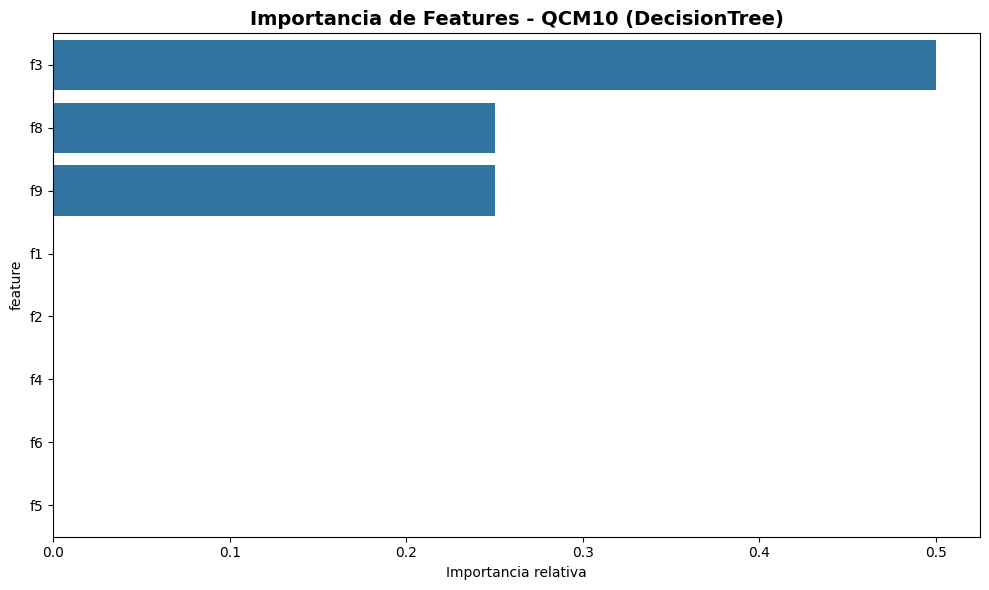

In [7]:
# Feature importance CORREGIDO para QCM10 usando DATA filtrado
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

numeric_features = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']

# FILTRAR data por QCM10
data_qcm10 = data[data['sensor'] == 'QCM10'].copy()
X_qcm10 = data_qcm10[numeric_features]  # ← USA data filtrado, NO qcm10
y_qcm10 = data_qcm10['solvente']

# Split
X_train10, X_test10, y_train10, y_test10 = train_test_split(
    X_qcm10, y_qcm10, train_size=0.8, random_state=42, stratify=y_qcm10
)

# Escalar
scaler10 = StandardScaler()
X_train10_scaled = scaler10.fit_transform(X_train10)

# DecisionTree
tree = DecisionTreeClassifier(random_state=42, max_depth=5)
tree.fit(X_train10_scaled, y_train10)

# IMPORTANCIA FEATURES
importancia = pd.DataFrame({
    'feature': numeric_features,
    'importance': tree.feature_importances_
}).sort_values('importance', ascending=False)

print("🔥 TOP 5 FEATURES QCM10:")
print(importancia.head())

# GRÁFICO para informe
plt.figure(figsize=(10,6))
sns.barplot(data=importancia.head(8), x='importance', y='feature')
plt.title("Importancia de Features - QCM10 (DecisionTree)", fontsize=14, fontweight='bold')
plt.xlabel("Importancia relativa")
plt.tight_layout()
plt.savefig('feature_importance_qcm10.png', dpi=300, bbox_inches='tight')
plt.show()


In [8]:
# RÁPIDO - solo para confirmar F1-scores
print("F1 QCM3:", f1_qcm3)
print("F1 QCM10:", f1_qcm10) 
print("F1 QCM12:", f1_qcm12)


F1 QCM3: 1.0
F1 QCM10: 1.0
F1 QCM12: 1.0


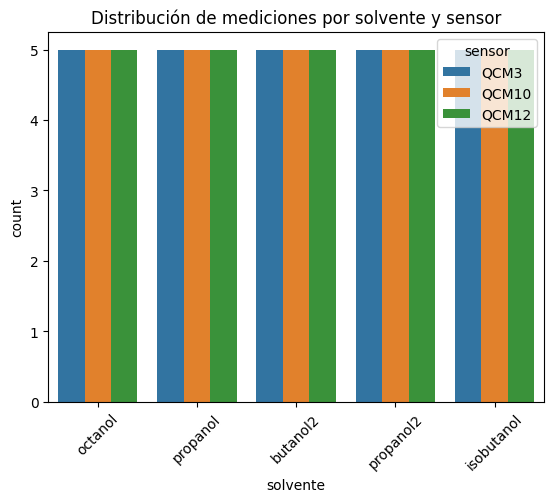

In [9]:
sns.countplot(x="solvente", hue="sensor", data=data)
plt.xticks(rotation=45)
plt.title("Distribución de mediciones por solvente y sensor")
plt.show()


# Definición de variable objetivo y features

In [10]:
# 1. Definir SOLO las columnas NUMÉRICAS como features
numeric_features = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
X = data[numeric_features]  # SOLO 10 columnas numéricas
y = data["solvente"]

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Tipos de datos en X:")
print(X.dtypes)



Shape X: (75, 10)
Shape y: (75,)
Tipos de datos en X:
f1     float64
f2     float64
f3     float64
f4     float64
f5     float64
f6     float64
f7     float64
f8     float64
f9     float64
f10    float64
dtype: object


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("Listo para modelar!")


X_train_scaled shape: (60, 10)
Listo para modelar!


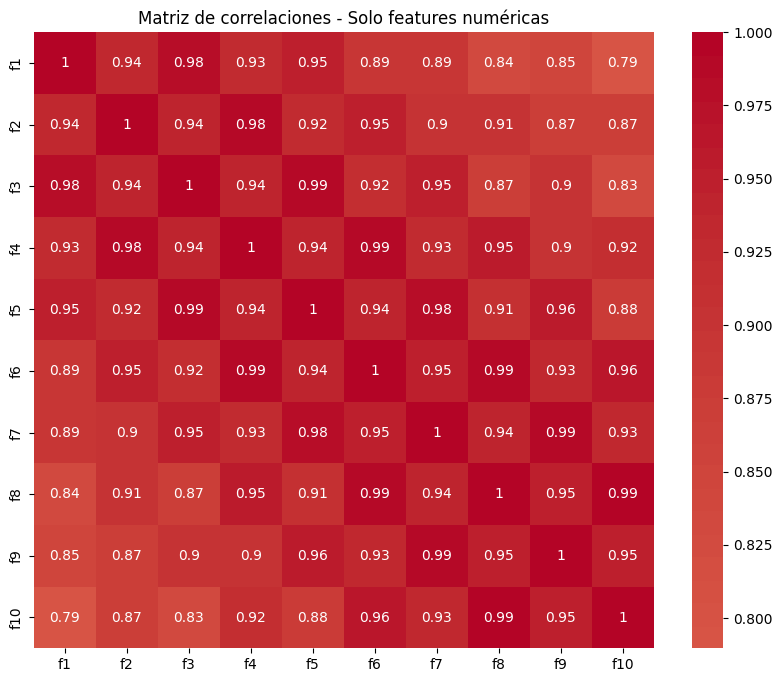

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlaciones - Solo features numéricas")
plt.show()


# Entrenamiento de modelos de clasificación

In [12]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred))
    print()
    results[name] = (y_test, y_pred)


=== LogisticRegression ===
              precision    recall  f1-score   support

    butanol2       0.67      0.67      0.67         3
  isobutanol       1.00      1.00      1.00         3
     octanol       1.00      1.00      1.00         3
    propanol       0.00      0.00      0.00         3
   propanol2       0.40      0.67      0.50         3

    accuracy                           0.67        15
   macro avg       0.61      0.67      0.63        15
weighted avg       0.61      0.67      0.63        15


=== KNN ===
              precision    recall  f1-score   support

    butanol2       1.00      1.00      1.00         3
  isobutanol       1.00      1.00      1.00         3
     octanol       1.00      1.00      1.00         3
    propanol       1.00      1.00      1.00         3
   propanol2       1.00      1.00      1.00         3

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00    

In [13]:
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f"{name} - CV accuracy: {scores.mean():.3f} ± {scores.std():.3f}")


LogisticRegression - CV accuracy: 0.633 ± 0.067
KNN - CV accuracy: 0.850 ± 0.097
DecisionTree - CV accuracy: 0.883 ± 0.085


# Evaluación y comparación de modelos

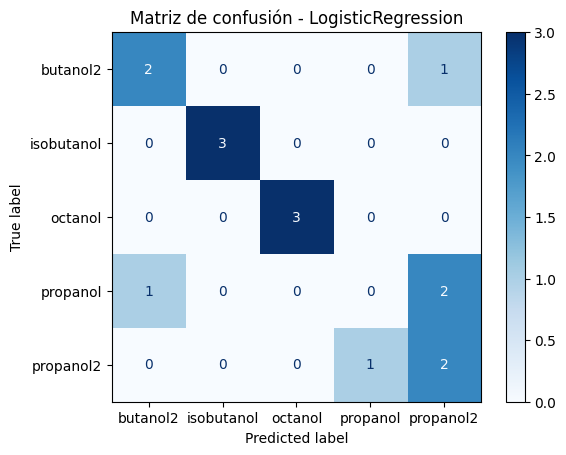

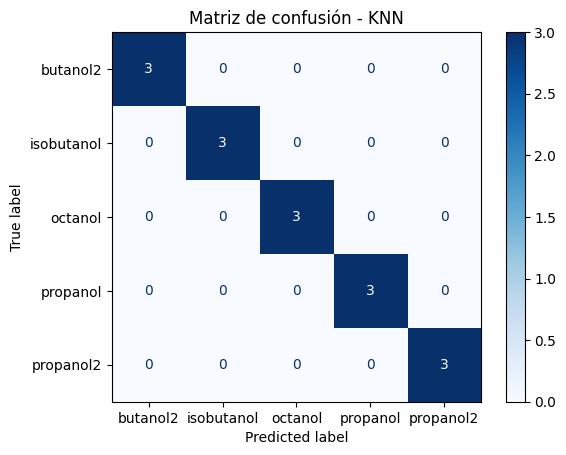

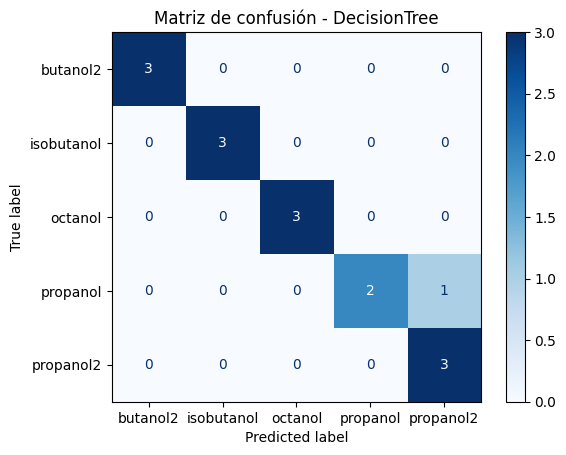

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

for name, (yt, yp) in results.items():
    cm = confusion_matrix(yt, yp, labels=sorted(y.unique()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=sorted(y.unique()))
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de confusión - {name}")
    plt.show()
